# MLCC-2nd

분석자: 김길호 (Last update: 2018/02/09)

## Problem definition, evaluation 및 데이터셋 관련 기본 정보

- 데이터셋 저장 경로: //211.106.187.119/Data/006_samsung_electro_mechanics/MLCC/2차/original_crop192x128
- 산업 도메인: MLCC
- 문제 유형: Classification
- 클래스 유형: Binary-class
    - 실제 결함은 9종이나, 이들을 모두 'defect'이라는 하나의 클래스로 통합함
    - 클래스 이름 별 제품 인스턴스 수(고객사가 제시한 training/test set 기준)
        - Training set
            - 'normal': 3974, 'defect': 3946
        - Test set
            - 'normal': 994, 'defect': 986
- 이미지 유형: Single-image (주: 하나의 이미지가 하나의 제품 인스턴스에 대응)
- 원본 이미지 크기 및 채널 수: 192 x 128 x 3
- Evaluation
    - Evaluation metric: Error rate
    - Evaluation method: 하나의 원본 이미지를 하나의 제품 인스턴스로 하여 성능 도출
- 분석 소스 코드(참조용)

In [1]:
import os, sys
sys.path.append('..')
import time
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches
import json
from skimage.io import imread, imsave

from datasets import mlcc_2nd as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from datasets.utils import view_image_samples, view_image_cam_pairs, \
                           view_image_cam_pairs_with_entropy, view_tsne_embeddings
from models.utils import grad_cam, get_feature_maps

In [2]:
image_save_dir = './images/'

In [3]:
""" Load dataset """
#root_dir = os.path.join('/', 'mnt', 'sdb2', 'New-ML-Data',
#                        '006_samsung_electro_mechanics', 'MLCC', 
#                        '2차', 'original_crop192x128')
root_dir = ('/Data/006_samsung_electro_mechanics/original_crop192x128')

---

## 탐색적 데이터 분석 결과

In [4]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
    
class_filenames_dict = dict()
for c in anno_dict['classes'].values():
    class_filenames_dict[c] = []
#print(len(class_filenames_dict))
print(anno_dict['classes'][str(0)])

00


In [5]:
#print(class_filenames_dict)
filename_list = anno_dict['images'].keys()
#print(len(filename_list))
for filename in filename_list:
    #print(filename)
    cs = anno_dict['images'][filename]['class']
    if 'train' in filename:
        for c in cs:
            #print("cs:",cs)
            #print(class_filenames_dict[0])
            #class_filenames_dict[c].append(filename)
            class_filenames_dict[anno_dict['classes'][str(c)]].append(filename)
# $ class_filenames_dict
# > {'07': [], '08': [], ..., '06': ['06__train__Image06_00219_J00.png'], ..., '01':[]}

### 제품 원본 이미지 예시

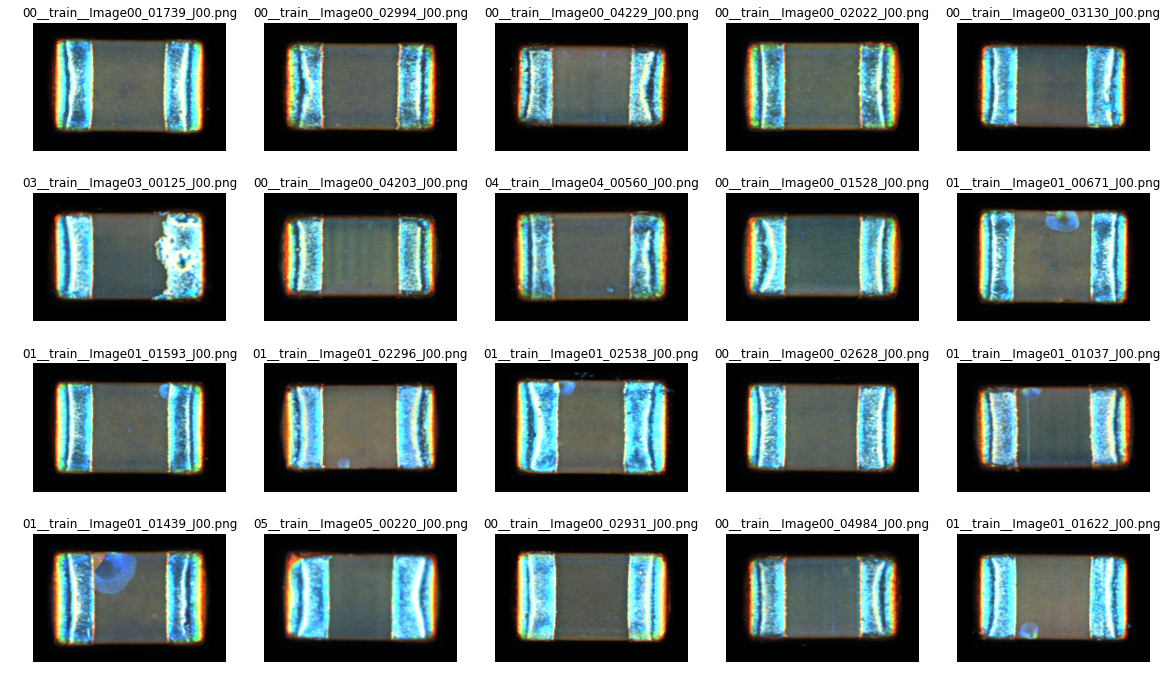

In [6]:
n_cols, n_rows = 5, 4
n_samples = n_cols * n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
total_filenames_list = []
for c in class_filenames_dict.keys():
    total_filenames_list += class_filenames_dict[c]
# total_filenames_list > ['-.png', '-.png', ..., '-png']
# len > 7920

sample_filenames = np.random.choice(total_filenames_list, size=n_samples, replace=False)
for j in range(n_rows):
    for i in range(n_cols):
        idx = n_cols*j+i
        filename = sample_filenames[idx]
        file_path = os.path.join(root_dir, 'image', filename)
        image = imread(file_path)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title(filename)
plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')

### (Labeling, Preprocessing 적용 후) 각 클래스 별 input 이미지 예시

#### 'normal' 클래스

In [10]:
X_train, y_train = dataset.read_mlcc_2nd_subset(root_dir, binary=True, mode='train', 
                                                sample_size=100)
X_train_normal = X_train[y_train[:, 0] == 1]
X_train_defect = X_train[y_train[:, 1] == 1]

Reading subset data...0/100
Done


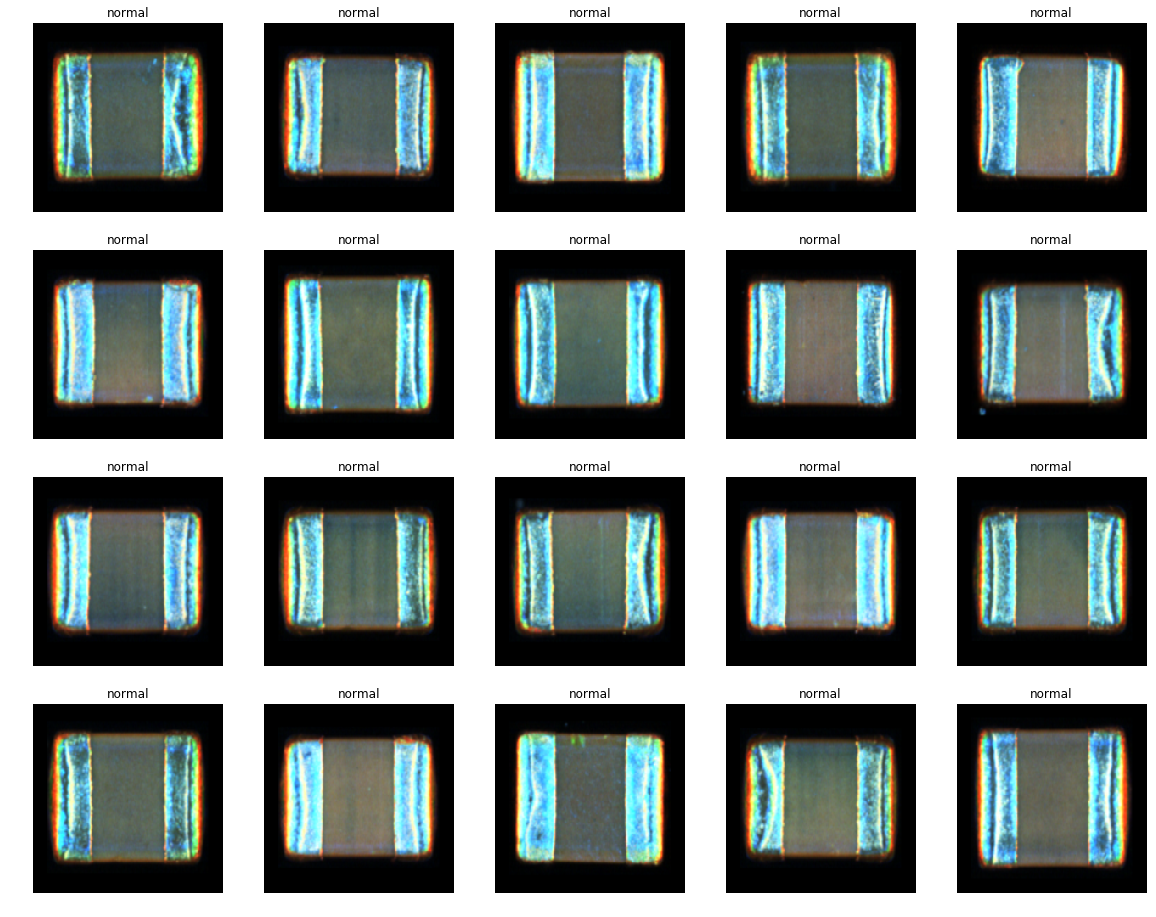

In [11]:
n_cols, n_rows = 5, 4
n_samples = n_cols * n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for j in range(n_rows):
    for i in range(n_cols):
        idx = n_cols*j+i
        image = X_train_normal[idx].transpose(1, 2, 0)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title('normal')
plt.savefig(os.path.join(image_save_dir, 'item_normal_samples.png'), bbox_inches='tight')

#### 'defect' 클래스

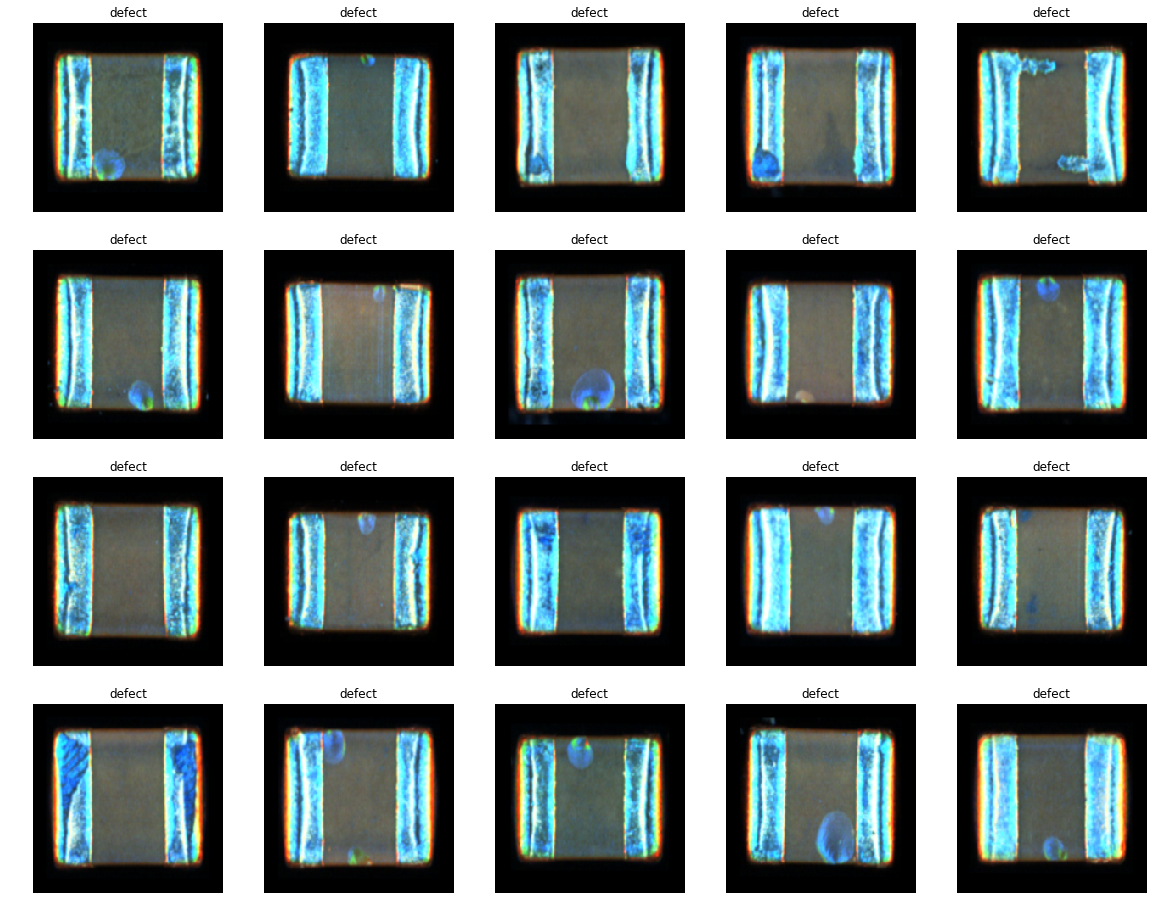

In [12]:
n_cols, n_rows = 5, 4
n_samples = n_cols * n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for j in range(n_rows):
    for i in range(n_cols):
        idx = n_cols*j+i
        image = X_train_defect[idx].transpose(1, 2, 0)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title('defect')
plt.savefig(os.path.join(image_save_dir, 'item_defect_samples.png'), bbox_inches='tight')

- 제품의 크기가 고정적이지 않으며, 제품의 좌우 끝의 '하늘색 영역'의 크기도 가변적임
    - **Data augmentation 수행 시, 제품의 크기 및 세부 부분의 모양에 변동성이 존재함을 반영할 수 있을 것으로 보임**
- '결함 자체'를 기준으로 하면, 결함이 발생하는 영역이 제한되어 있지 않고, 제품 영역 전체에서 발생할 수 있음
- 실제 '결함 유형'을 기준으로 하면, 결함 유형 중 일부는 가운데 '회색 영역'에서만, 일부는 좌우 끝의 '하늘색 영역'에서만 발생함
    - **추후 '결함 유형'을 클래스로 하여 결함 분류를 수행할 시, 위치적 정보를 주요 features로 반영할 수 있을 것으로 보임**

---

## 초기 학습 및 테스트 방법

### Architecture

- ResNet-18

### Optimization, Regularization

#### Parameter initialization

- He et al.의 normal initialization 방법을 채택함
    - He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.
    
#### Gradient descent optimizer

- SGD + momentum

#### Training hyperparameters

- Batch size: 64
- Number of epochs: 300
- Initial learning rate: 0.1
- Momentum: 0.9
- Learning rate decay schedule: validation 성능이 plateau를 보일 때마다, 기존 learning rate를 decay 
    - learning rate patience = 30
    - validation score threshold: 1e-4
    - learning rate decay: 0.1
        - 위의 각 hyperparameters에 대한 설명의 경우, SuaLab 기술 블로그의 AlexNet 학습 부분 참조
- Batch sampling 방법: uniform sampling
    - 'normal':'defect' 비율이 약 1:1에 가까웠기 때문에, stratified sampling이 필요하지 않았음
    
#### Regularization

- L2 weight decay: 0.0001
- Data augmentation: LR flip, UD flip (4x augmentation)
    - Training 시에만 LR flip, UD flip, LR+UD flip 각각 25% 확률로 augmentation 수행
    - Test 시에는 augmentation을 수행하지 않음
- Batch normalization
    - 모든 conv layer와 ReLU layer 사이에 batch normalization을 적용

---

## 초기 분석 결과 및 체크리스트 관련 코멘트

In [13]:
# Load test set
X_test, y_test = dataset.read_mlcc_2nd_subset(root_dir, binary=True, mode='test')
test_set = dataset.DataSet(X_test, y_test)

Reading subset data...1900/1980
Done


In [14]:
# Sanity check
print('Test set stats:')
print(test_set.images.shape)
print(test_set.images.min(), test_set.images.max())
print((test_set.labels[:, 1] == 0).sum(), (test_set.labels[:, 1] == 1).sum())

Test set stats:
(1980, 3, 224, 224)
0.0 1.0
994 986


In [15]:
""" Set test hyperparameters """
hp_d = dict()
image_mean = np.load('/tmp/mlcc_2nd_mean.npy')    # load mean image
hp_d['image_mean'] = image_mean

# FIXME: Test hyperparameters
hp_d['batch_size'] = 256
hp_d['augment_pred'] = False

In [16]:
""" Load weights and start test """
model = ConvNet([3, 224, 224], 2, **hp_d)
model.logits.restore('/tmp/model.dnn')
evaluator = Evaluator()
start_time = time.time()
test_y_pred = model.predict(test_set, **hp_d)

total_time = time.time() - start_time

conv1.shape (64, 112, 112)
pool1.shape (64, 56, 56)
conv2_2.shape (64, 56, 56)
conv3_2.shape (128, 28, 28)
conv4_2.shape (256, 14, 14)
conv5_2.shape (512, 7, 7)
pool6.shape (512, 1, 1)


ValueError: Function 'Composite(Dense): Input('features', [#], [3 x 224 x 224]) -> Output('Block4720_Output_0', [#], [2])' being restored is not equivalent (isomorphic) to the Function 'Composite(Dense): Input('features', [#], [3 x 224 x 224]) -> Output('Block15230_Output_0', [#], [15])' loaded from checkpoint.

[CALL STACK]
[0x7f3de9aea5f9]                                                       + 0x88d5f9
[0x7f3de9af6a83]    CNTK::Function::  RestoreFromCheckpoint  (CNTK::Dictionary const&) + 0x303
[0x7f3de9af5925]    CNTK::Function::  Restore  (std::__cxx11::basic_string<wchar_t,std::char_traits<wchar_t>,std::allocator<wchar_t>> const&) + 0x85
[0x7f3dea825173]                                                       + 0x1b7173
[0x562250635d4b]    PyCFunction_Call                                   + 0x4b
[0x56225068c85c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x56225068cf10]    PyEval_EvalFrameEx                                 + 0xab0
[0x5622506979f3]    PyEval_EvalCodeEx                                  + 0x693
[0x562250698fef]                                                       + 0x1b0fef
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x56225068f078]    PyEval_EvalFrameEx                                 + 0x2c18
[0x562250691dc0]    PyEval_EvalFrameEx                                 + 0x5960
[0x56225069756d]    PyEval_EvalCodeEx                                  + 0x20d
[0x56225069848c]    PyEval_EvalCode                                    + 0x1c
[0x5622506f4d8b]                                                       + 0x20cd8b
[0x562250635d4b]    PyCFunction_Call                                   + 0x4b
[0x56225068c85c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x562250691790]    PyEval_EvalFrameEx                                 + 0x5330 (x2)
[0x562250697eb9]    PyEval_EvalCodeEx                                  + 0xb59
[0x562250698fef]                                                       + 0x1b0fef
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x56225068f078]    PyEval_EvalFrameEx                                 + 0x2c18
[0x562250691dc0]    PyEval_EvalFrameEx                                 + 0x5960
[0x562250691790]    PyEval_EvalFrameEx                                 + 0x5330
[0x56225068cf10]    PyEval_EvalFrameEx                                 + 0xab0 (x2)
[0x562250697eb9]    PyEval_EvalCodeEx                                  + 0xb59
[0x562250698fef]                                                       + 0x1b0fef
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x56225068f078]    PyEval_EvalFrameEx                                 + 0x2c18
[0x562250697eb9]    PyEval_EvalCodeEx                                  + 0xb59
[0x562250698fef]                                                       + 0x1b0fef
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x56225068f078]    PyEval_EvalFrameEx                                 + 0x2c18
[0x562250691790]    PyEval_EvalFrameEx                                 + 0x5330
[0x56225068cf10]    PyEval_EvalFrameEx                                 + 0xab0
[0x56225069756d]    PyEval_EvalCodeEx                                  + 0x20d
[0x562250698fef]                                                       + 0x1b0fef
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x56225068f078]    PyEval_EvalFrameEx                                 + 0x2c18
[0x562250691dc0]    PyEval_EvalFrameEx                                 + 0x5960
[0x56225068cf10]    PyEval_EvalFrameEx                                 + 0xab0
[0x562250691dc0]    PyEval_EvalFrameEx                                 + 0x5960
[0x56225068cf10]    PyEval_EvalFrameEx                                 + 0xab0
[0x562250691790]    PyEval_EvalFrameEx                                 + 0x5330
[0x56225069756d]    PyEval_EvalCodeEx                                  + 0x20d
[0x56225069848c]    PyEval_EvalCode                                    + 0x1c
[0x5622506f4d8b]                                                       + 0x20cd8b
[0x562250635d4b]    PyCFunction_Call                                   + 0x4b
[0x56225068c85c]    PyEval_EvalFrameEx                                 + 0x3fc
[0x562250691790]    PyEval_EvalFrameEx                                 + 0x5330
[0x56225069756d]    PyEval_EvalCodeEx                                  + 0x20d
[0x562250698e89]                                                       + 0x1b0e89
[0x5622505e91ea]    PyObject_Call                                      + 0x3a
[0x5622506e5567]                                                       + 0x1fd567
[0x5622506f5697]    Py_Main                                            + 0x317
[0x5622505bfe91]    main                                               + 0xe1
[0x7f3e2d79f830]    __libc_start_main                                  + 0xf0
[0x562250699e28]                                                       + 0x1b1e28


In [39]:
test_score = evaluator.score(test_set.labels, test_y_pred)
print('Test error rate: {}'.format(test_score))

Test error rate: 0.05959595959595965


### Performance - training set size plot

In [40]:
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Load results from pickle file
with open('cv_mlcc_2nd_resnet_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)
# test_result_dict[fold_idx][trainval_ratio]
# >> fold_idx = 0 -> {1.0,0.75,0.5,0.25,...}
# >> fold_idx = 1 -> {1.0,0.75, ...}
# >> ...
# >> fold_idx = 4 -> {1.0,0.75, ...}

FileNotFoundError: [Errno 2] No such file or directory: 'cv_mlcc_2nd_resnet_test_result.pkl'

In [ ]:
test_score_per_train_portion = dict()
for fold_idx in test_result_dict.keys():
    for portion in test_result_dict[fold_idx].keys():
        if portion not in test_score_per_train_portion:
            test_score_per_train_portion[portion] = []
        test_score_per_train_portion[portion].append(test_result_dict[fold_idx][portion])
# test_score_per_train_portion
# >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}

In [ ]:
total_set_size = 9900    # FIXME
# total_set_size = X_trainval.shape[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = [v*total_set_size for v in sorted(test_score_per_train_portion.keys())]
y_mean = [np.mean(l) for k, l in sorted(test_score_per_train_portion.items())]
y_std = [np.std(l) for k, l in sorted(test_score_per_train_portion.items())]
_ = ax.plot(x, y_mean, color='b', label='ResNet-18')
_ = ax.errorbar(x, y_mean, yerr=y_std, color='b')
_ = ax.set_title('5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Training+Validation set size')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig(os.path.join(image_save_dir, 'cross_validation_results.png'), bbox_inches='tight')

# >> output: accuracy graph averaged over 5 folds

- 전체 데이터셋의 12.5%(1,238장)에 해당하는 크기를 trainval에 사용할 때까지는 성능 하락의 폭이 상대적으로 작으나, 이보다 작은 크기를 사용할 시 성능 하락의 폭이 급격하게 커지며, 성능의 표준편차도 동시에 커지는 것을 확인할 수 있음
    - 이는, 12.5% 미만 크기의 trainval set에 대해서는 모델의 일반화 성능이 낮아지면서, 동시에 모델이 dataset bias에 민감하게 반응함을 보여줌

### Tact time 측정 결과

In [ ]:
print('Total tact time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / test_set.num_examples))

### Confusion matrix 결과

In [ ]:
y_true_labels = test_set.labels.argmax(axis=1)
y_pred_labels = test_y_pred.argmax(axis=1)
c_mat = confusion_matrix(y_true_labels, y_pred_labels)
print(c_mat)    
# C_{i, j}: the number of observations known to be in group `i`, 
#           but predicted to be in group `j`.

fn_idxs = np.arange(X_test.shape[0])[(y_true_labels == 1) & (y_pred_labels == 0)]
fp_idxs = np.arange(X_test.shape[0])[(y_true_labels == 0) & (y_pred_labels == 1)]
tn_idxs = np.arange(X_test.shape[0])[(y_true_labels == 0) & (y_pred_labels == 0)]
tp_idxs = np.arange(X_test.shape[0])[(y_true_labels == 1) & (y_pred_labels == 1)]

| |  PN |  PP |
|-----|-----|-----|
|  **AN** | 959 | 35  |
|  **AP** | 76  | 910 |

- PN: Predicted Negative
- PP: Predicted Positive
- AN: Actually Negative
- AP: Actually Positive

### CAM visualization on the feature layer

In [ ]:
test_pos_cam = grad_cam(model, test_set, 1, 'conv5_2', **hp_d)
test_neg_cam = grad_cam(model, test_set, 0, 'conv5_2', **hp_d)
print(test_pos_cam.shape)
print(test_pos_cam.min(), test_pos_cam.max())
print(test_neg_cam.shape)
print(test_neg_cam.min(), test_neg_cam.max())

#### True Positives

In [ ]:
num_tp_samples = 40
n_cols = 8
n_rows = math.ceil(num_tp_samples / n_cols)

image_cam_samples = view_image_cam_pairs_with_entropy(test_set.images[tp_idxs], 
                                                      test_pos_cam[tp_idxs],
                                                      test_y_pred[tp_idxs],
                                                      n_samples=num_tp_samples, border=2, 
                                                      n_cols=n_cols)
fig, ax = plt.subplots(1, 1, figsize=(2*n_cols, 4*n_rows))
_ = ax.imshow(image_cam_samples, vmin=0.0, vmax=1.0)
_ = ax.axis('off')
_ = ax.set_title('CAM visualization examples: True Positives')
plt.savefig(os.path.join(image_save_dir, 'true_positive_cams.png'), bbox_inches='tight')

- 대부분의 TP 이미지의 경우, 모델이 결함 영역에 집중하여 예측하였음을 확인할 수 있음
- 결함 대상 자체의 크기가 지배적으로 크지 않음에도 불구하고, 제품 이미지 자체가 어느 정도 정형적인 속성을 지니면서 동시에 결함 영역이 색상적으로 도드라지기 때문에, 모델이 이를 기반으로 예측을 수행할 수 있었던 것으로 보임

#### False Positives

In [ ]:
num_fp_samples = 40
n_cols = 8
n_rows = math.ceil(num_fp_samples / n_cols)

image_cam_samples = view_image_cam_pairs_with_entropy(test_set.images[fp_idxs], 
                                                      test_pos_cam[fp_idxs],
                                                      test_y_pred[fp_idxs],
                                                      n_samples=num_fp_samples, border=2, 
                                                      n_cols=n_cols)
fig, ax = plt.subplots(1, 1, figsize=(2*n_cols, 4*n_rows))
_ = ax.imshow(image_cam_samples, vmin=0.0, vmax=1.0)
_ = ax.axis('off')
_ = ax.set_title('CAM visualization examples: False Positives')
plt.savefig(os.path.join(image_save_dir, 'false_positive_cams.png'), bbox_inches='tight')

- FP 이미지의 경우, 모델이 어느 정도 '의심할 만한' 영역에 집중하여 결함으로 예측한 것으로 보임
- '의심할 만한' 영역을 지닌 이미지들의 경우, 해당 영역이 (1) 실제 결함이 맞거나(레이블링 오류), (2) 결함으로 판정하기 '애매한' 경우에 해당함(레이블 애매성)
    - **이들의 레이블링을 수정하거나, 혹은 이들을 test set에서 제거할 경우 성능 향상을 거둘 수 있을 것으로 예상됨**

#### True Negatives

In [ ]:
num_tn_samples = 40
n_cols = 8
n_rows = math.ceil(num_tn_samples / n_cols)

image_cam_samples = view_image_cam_pairs_with_entropy(test_set.images[tn_idxs], 
                                                      test_neg_cam[tn_idxs],
                                                      test_y_pred[tn_idxs],
                                                      n_samples=num_tn_samples, border=2, 
                                                      n_cols=n_cols)
fig, ax = plt.subplots(1, 1, figsize=(2*n_cols, 4*n_rows))
_ = ax.imshow(image_cam_samples, vmin=0.0, vmax=1.0)
_ = ax.axis('off')
_ = ax.set_title('CAM visualization examples: True Negatives')
plt.savefig(os.path.join(image_save_dir, 'true_negative_cams.png'), bbox_inches='tight')

- TN 이미지의 경우, entropy가 낮은 이미지들의 경우 모델이 대체로 제품 영역을 전역적으로 관찰하여 예측을 수행한 반면, entropy가 높은 이미지들의 경우 제품의 특정 영역에 집착하여 예측을 수행한 것으로 보임
- '의심할 만한' 영역이 존재하는 이미지의 경우, 해당 영역을 피하여 CAM이 활성화된 것을 확인할 수 있음
    - 해당 영역은, 주어진 이미지가 정상이라고 예측하기에 그 증거로 삼을 만한 경향이 낮기 때문으로 파악됨

#### False Negatives

In [ ]:
num_fn_samples = 80
n_cols = 8
n_rows = math.ceil(num_fn_samples / n_cols)

image_cam_samples = view_image_cam_pairs_with_entropy(test_set.images[fn_idxs], 
                                                      test_neg_cam[fn_idxs],
                                                      test_y_pred[fn_idxs],
                                                      n_samples=num_fn_samples, border=2, 
                                                      n_cols=n_cols)
fig, ax = plt.subplots(1, 1, figsize=(2*n_cols, 4*n_rows))
_ = ax.imshow(image_cam_samples, vmin=0.0, vmax=1.0)
_ = ax.axis('off')
_ = ax.set_title('CAM visualization examples: False Negatives')
plt.savefig(os.path.join(image_save_dir, 'false_negative_cams.png'), bbox_inches='tight')

- FN 이미지의 경우에도, entropy가 낮은 이미지들의 경우 모델이 대체로 제품 영역을 전역적으로 관찰하여 예측을 수행한 반면, entropy가 높은 이미지들의 경우 제품의 특정 영역에 집착하여 예측을 수행한 것으로 보임
- Entropy가 낮은 이미지 중에서, 실제 정상으로 보이는 이미지들을 다수 확인할 수 있음
    - **이들의 레이블링을 수정하거나, 혹은 이들을 test set에서 제거할 경우 성능 향상을 거둘 수 있을 것으로 예상됨**

## T-SNE visualization on the feature layer

In [ ]:
test_feature_maps = get_feature_maps(model, test_set, 'conv5_2', **hp_d)
print(test_feature_maps.shape)

In [ ]:
# Flatten feature maps into feature vectors
test_features = test_feature_maps.reshape((test_feature_maps.shape[0], -1))
print(test_features.shape)

In [ ]:
test_embeddings = TSNE(n_components=2, verbose=1).fit_transform(test_features)
print(test_embeddings.shape)

In [ ]:
from datasets.utils import view_tsne_embeddings

In [ ]:
emb_image = view_tsne_embeddings(test_embeddings, test_set.images, test_set.labels)
imsave(os.path.join(image_save_dir, 'convnet_embed.jpg'), emb_image)

- T-SNE visualization 결과, 모델이 인식하는 'normal' 클래스의 intra-class variability는 작으나, 'defect' 클래스의 intra-class variability는 상대적으로 큼
    - 'defect' 클래스 이미지들이, *실제 결함 종류*에 따라 clusters를 이루고 있음을 확인할 수 있음
        - 제품 이미지 중앙의 '회색 영역'에 있는 결함 종류 간의 거리가 서로 가깝고, 제품의 좌우 끝의 '하늘색 영역'에 있는 결함 종류 간의 거리가 서로 가까움
    - **실제 결함 종류별 clusters를 기준으로, 각 clusters 간의 거리 관계를 고려하여 추후 multi-class set을 구성하기 위한 class hierarchy를 설계할 수 있을 것으로 보임**
        - e.g. Class hierarchy의 가장 상위 레벨에 '회색 영역' 결함 vs '하늘색' 영역 결함을, 그 하위 레벨에 각 영역별 결함들을 subclass로 배치
- 두 클래스 간의 inter-class variability가, 모델로 하여금 두 클래스를 분류하는 데 있어 충분한 것으로 파악됨
    - 일부 경계에 위치하는 이미지들이 존재하나, 그 수가 많지는 않음
    - **해당 결과에서 파악된 경계성 이미지들을 제거하여, 동일한 실험을 다시 수행하였을 때 성능 변화가 발생하는지 관찰이 필요할 것으로 보임**

---

## 총평

- Data augmentation 수행 시 제품의 크기 및 세부 부분의 모양에 변동성이 존재함을 반영할 수 있을 것으로 보임
- 각 실제 '결함 종류'가 발생하는 위치가 대체로 고정되어 있기 때문에, 추후 '결함 종류'를 클래스로 하여 multi-class classification을 수행할 시 위치적 정보를 주요한 features로 반영할 수 있을 것으로 보임
- 초기 학습 및 테스트 결과, FP 또는 FN으로 예측된 이미지 중 레이블링 오류가 일부 존재하였는데, 이들의 레이블링을 수정하거나 또는 이들을 test set에서 제거하여 성능 향상을 거둘 수 있을 것으로 예상됨
- 초기 학습 및 테스트 결과, FP 또는 FN으로 예측된 이미지 중 경계성 이미지들이 존재하며, 이들을 다른 방법으로 처리하거나 혹은 제거하였을 때 테스트 성능 변화가 발생하는지 관찰이 필요할 것으로 보임
- 정상 클래스의 variability보다 결함 클래스의 variability가 상대적으로 더 크며, 실제 '결함 종류'에 따라 clusters를 이루고 있음을 확인함
    - '회색 영역' 결함 vs '하늘색 영역' 결함을 superclass로 설정하고, 그 하위 레벨에 각 영역별 결함들을 subclass로 설정하는 방식으로 class hierarchy를 수립하면 더 효과적인 분류가 가능할 것으로 예상됨